In [8]:
!pip install prophet

     --------------------------------------- 12.1/12.1 MB 14.2 MB/s eta 0:00:00
     ---------------------------------------- 83.2/83.2 kB ? eta 0:00:00
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
pjme =pd.read_csv(r"C:\Users\jongb\Downloads\archive\PJME_hourly.csv",
               index_col=[0],
                parse_dates=[0])

In [17]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


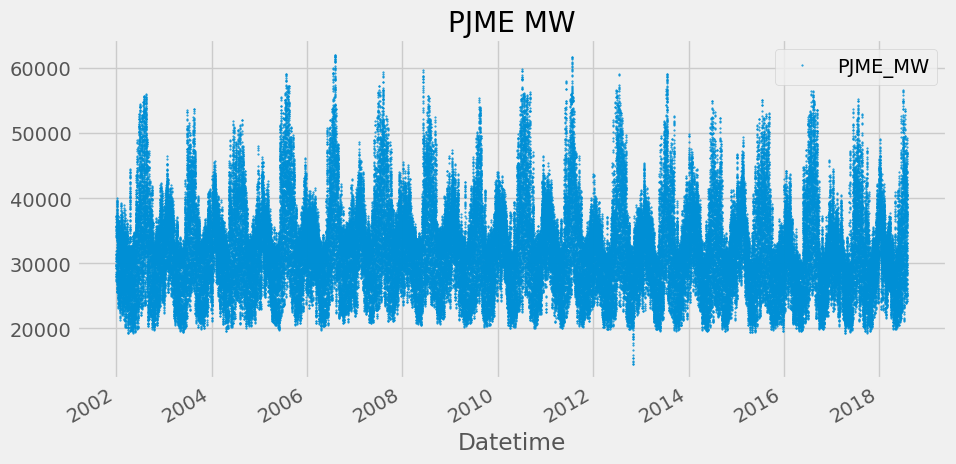

In [18]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

In [ ]:
###Time Series Features

In [19]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [20]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0


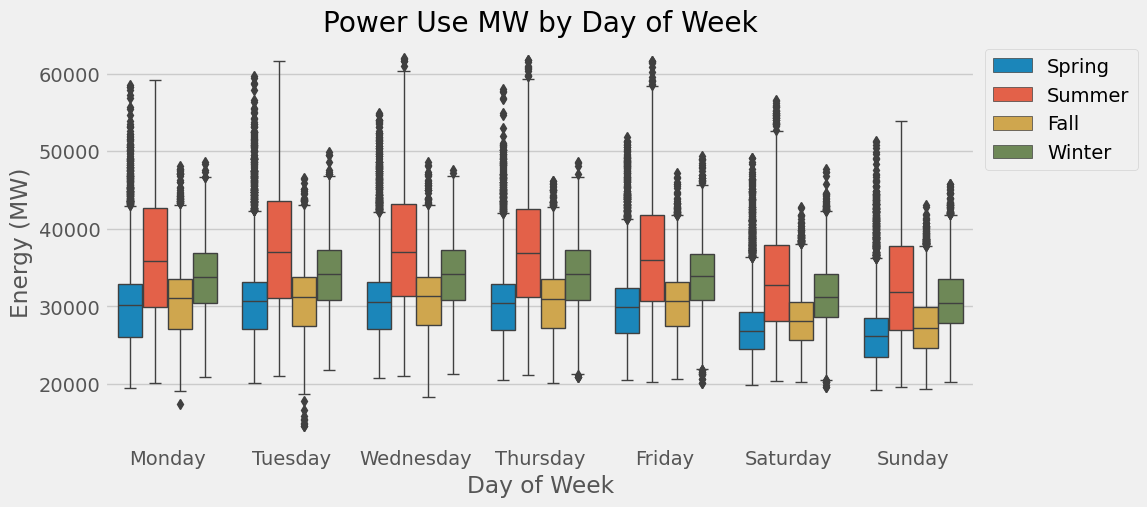

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
###Train / Test Split

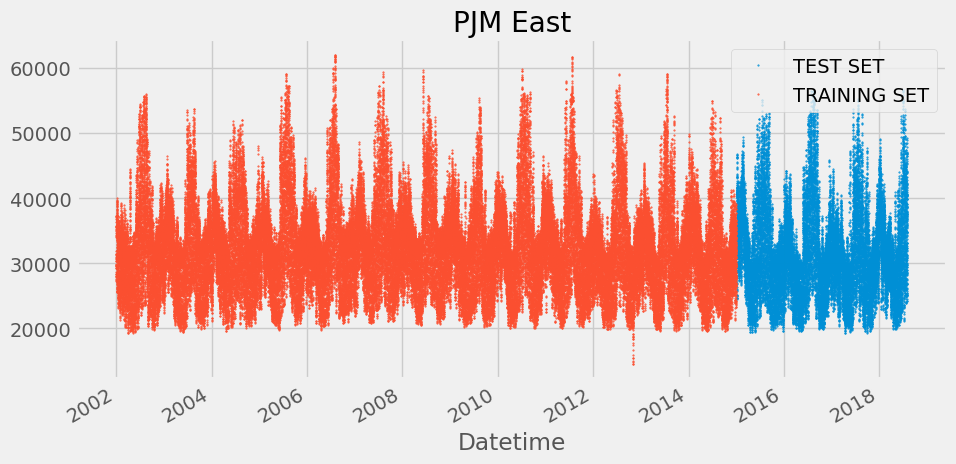

In [22]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

In [ ]:
###Simple Prophet Model

In [23]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [26]:
pjme_train_prophet

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
113922,2014-01-01 20:00:00,36193.0
113923,2014-01-01 21:00:00,35601.0
113924,2014-01-01 22:00:00,34242.0
113925,2014-01-01 23:00:00,32215.0


In [27]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

04:11:03 - cmdstanpy - INFO - Chain [1] start processing
04:12:19 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 6.42 s
Wall time: 1min 23s


In [28]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [31]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31203.428443,23788.128938,32701.485321,31203.428443,31203.428443,-2845.249382,-2845.249382,-2845.249382,-4430.355857,...,1281.388794,1281.388794,1281.388794,303.717681,303.717681,303.717681,0.0,0.0,0.0,28358.179061
1,2015-01-01 02:00:00,31203.390393,22555.721595,31143.719057,31203.390393,31203.390393,-4349.694004,-4349.694004,-4349.694004,-5927.332380,...,1272.625061,1272.625061,1272.625061,305.013315,305.013315,305.013315,0.0,0.0,0.0,26853.696389
2,2015-01-01 03:00:00,31203.352343,21359.195300,30466.679232,31203.352343,31203.352343,-5221.371965,-5221.371965,-5221.371965,-6790.378010,...,1262.655592,1262.655592,1262.655592,306.350452,306.350452,306.350452,0.0,0.0,0.0,25981.980378
3,2015-01-01 04:00:00,31203.314293,21224.828508,30397.853890,31203.314293,31203.314293,-5362.820050,-5362.820050,-5362.820050,-6922.153232,...,1251.604062,1251.604062,1251.604062,307.729120,307.729120,307.729120,0.0,0.0,0.0,25840.494243
4,2015-01-01 05:00:00,31203.276243,21737.200171,30933.791547,31203.276243,31203.276243,-4688.373560,-4688.373560,-4688.373560,-6237.129258,...,1239.606356,1239.606356,1239.606356,309.149342,309.149342,309.149342,0.0,0.0,0.0,26514.902682


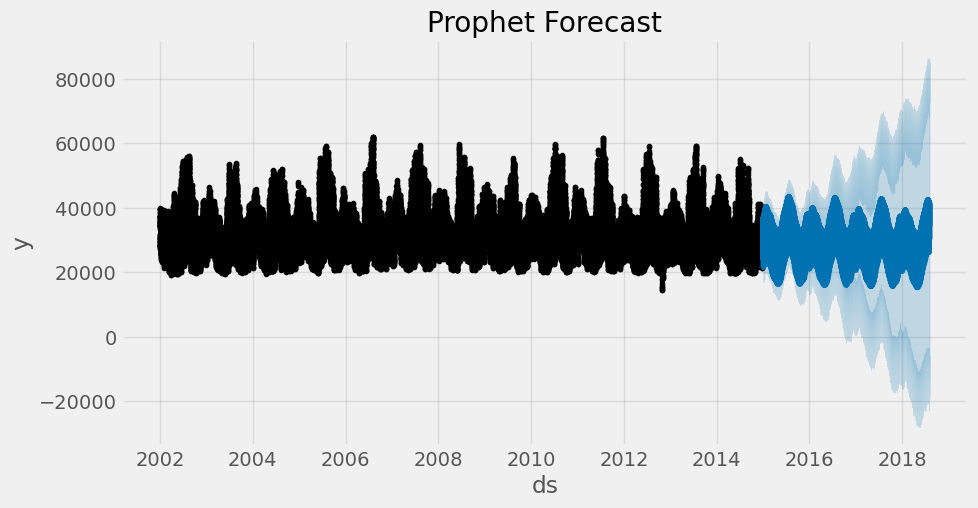

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

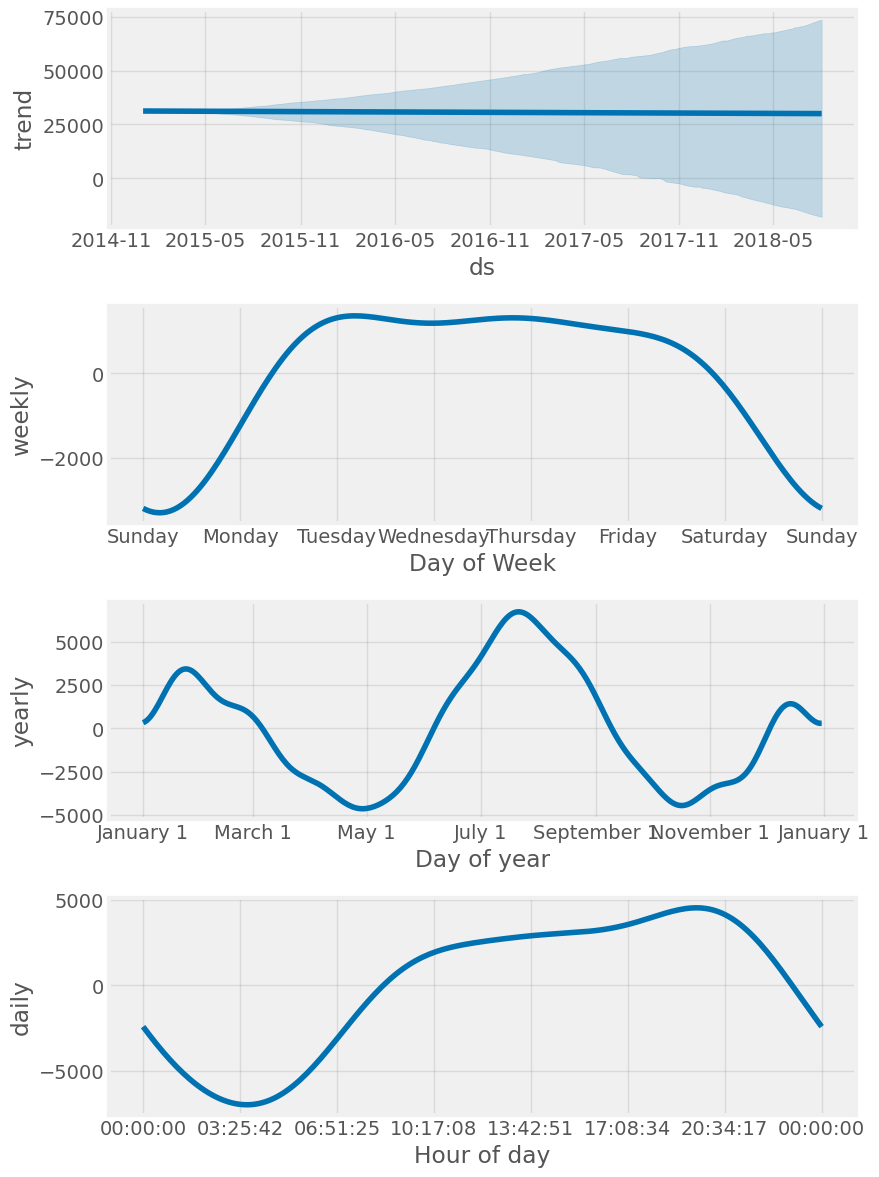

In [33]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

In [ ]:
###Compare Forecast to Actuals

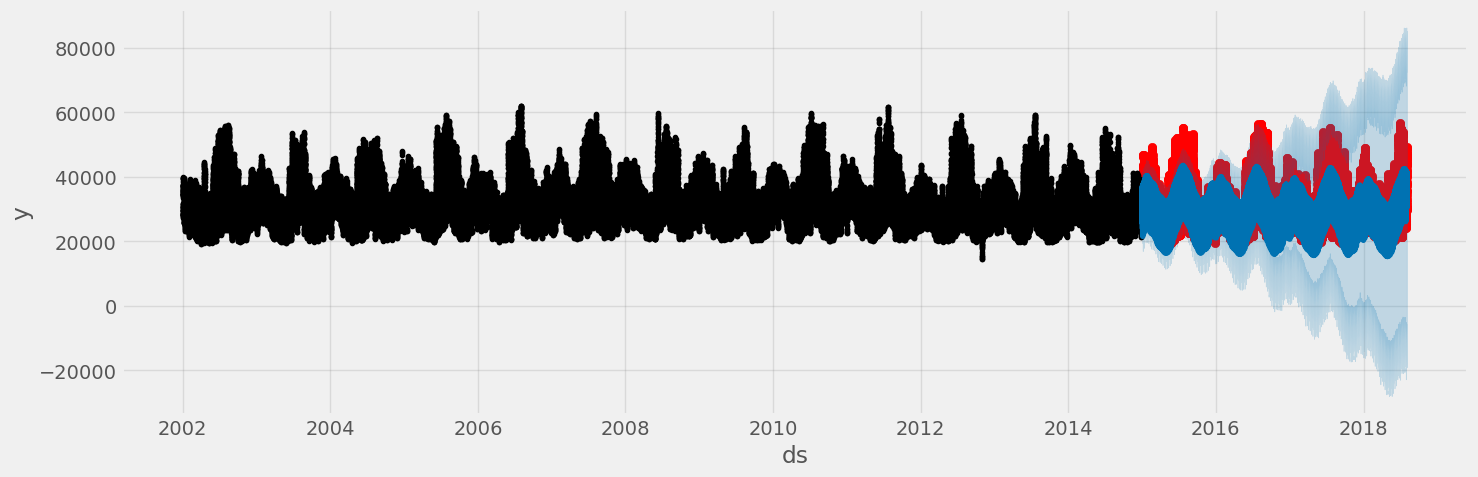

In [34]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

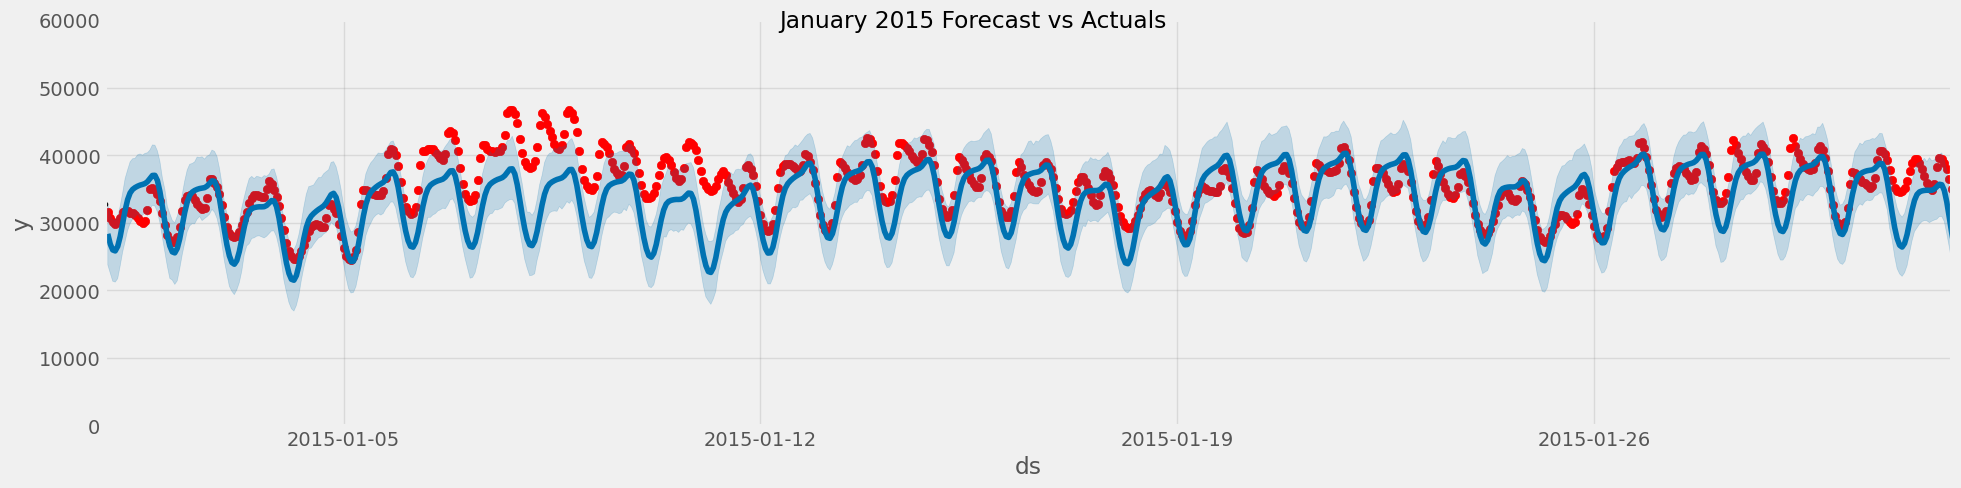

In [39]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015',
              upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')


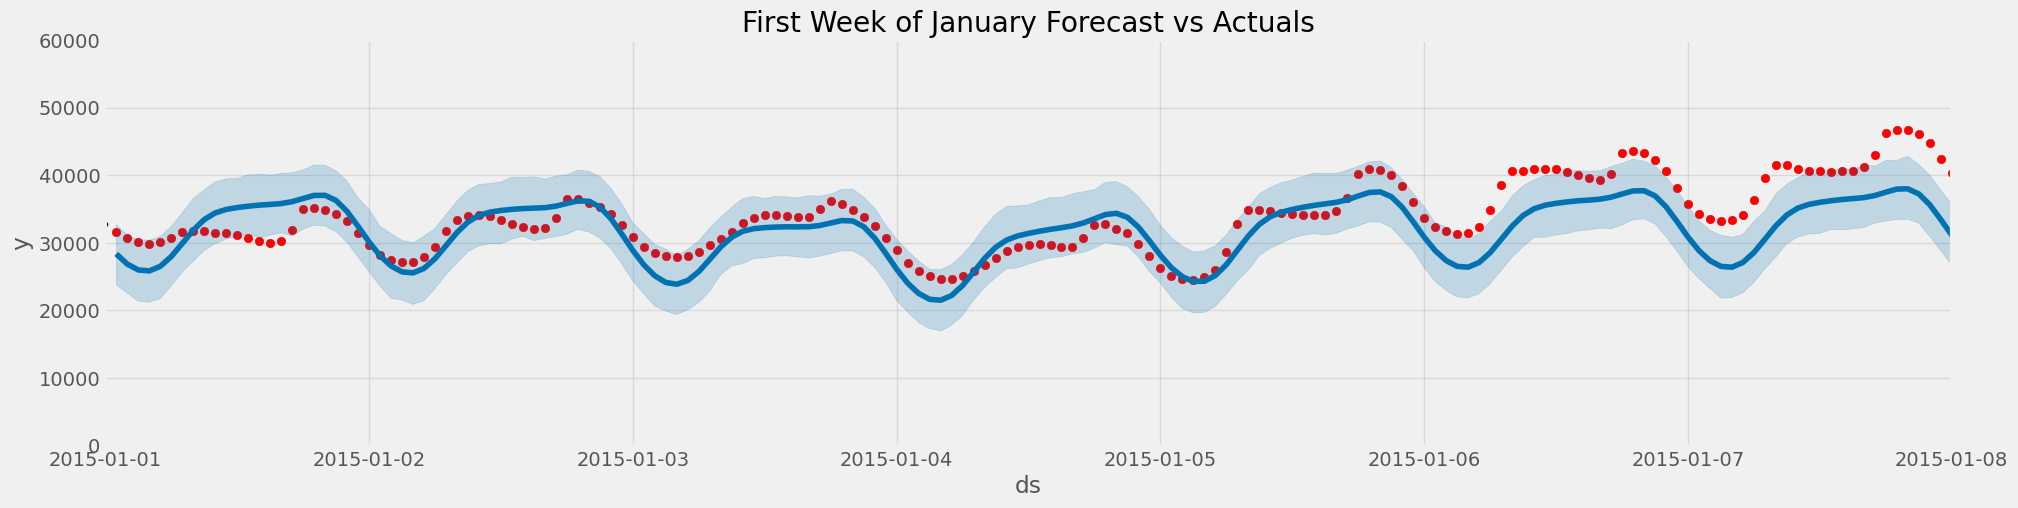

In [40]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(20, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

In [ ]:
###Evaluate the model with Error Metrics

In [41]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6617.868136902021

In [42]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5182.793987435976

In [43]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.506586588257765

In [ ]:
###Adding Holidays

In [44]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [45]:
cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [46]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

04:29:46 - cmdstanpy - INFO - Chain [1] start processing
04:31:09 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 6.94 s
Wall time: 1min 29s


In [47]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

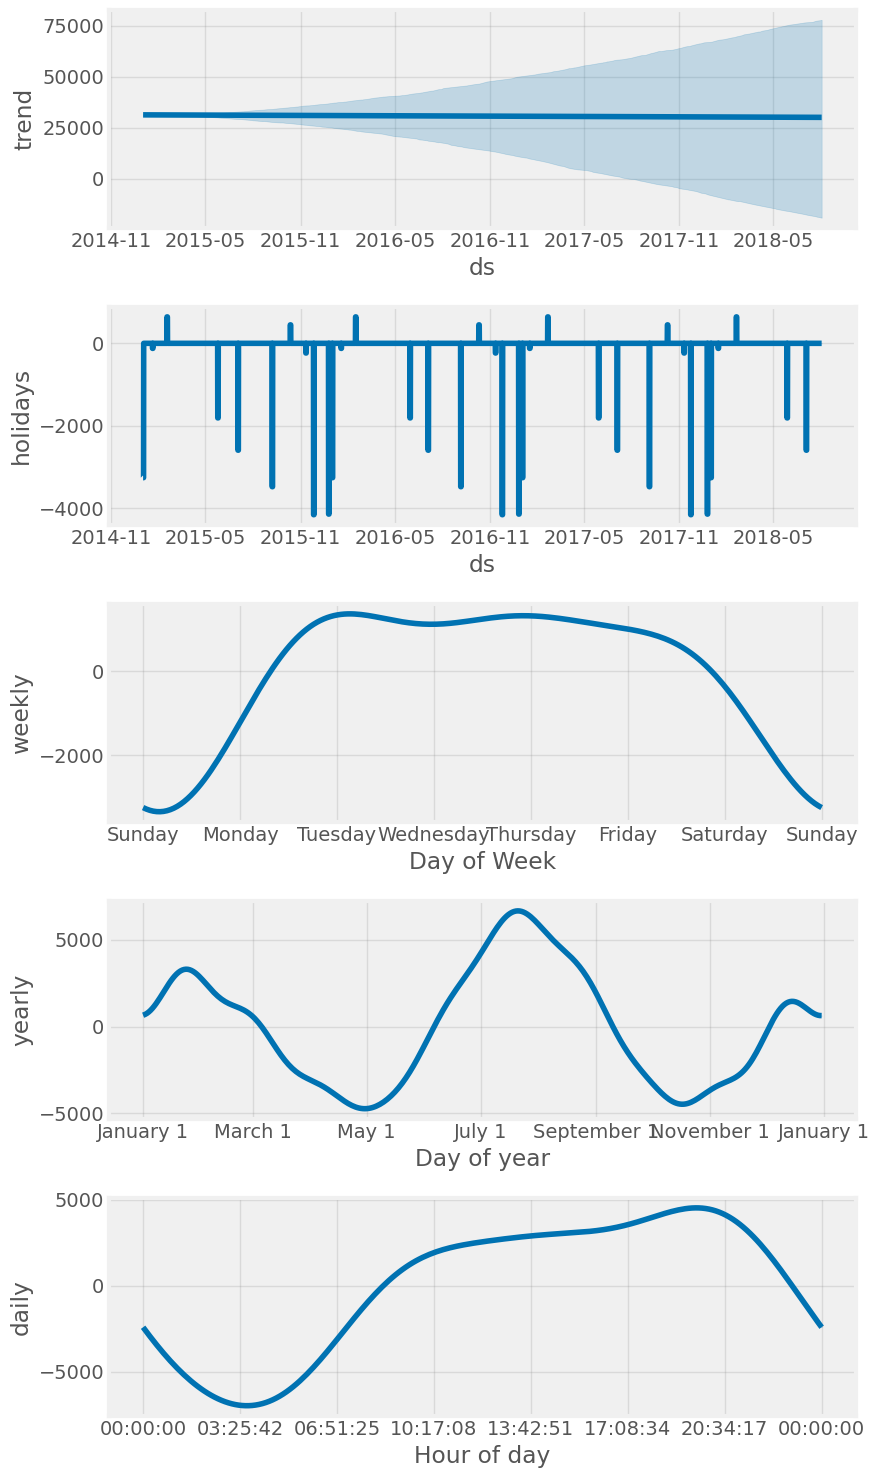

In [48]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

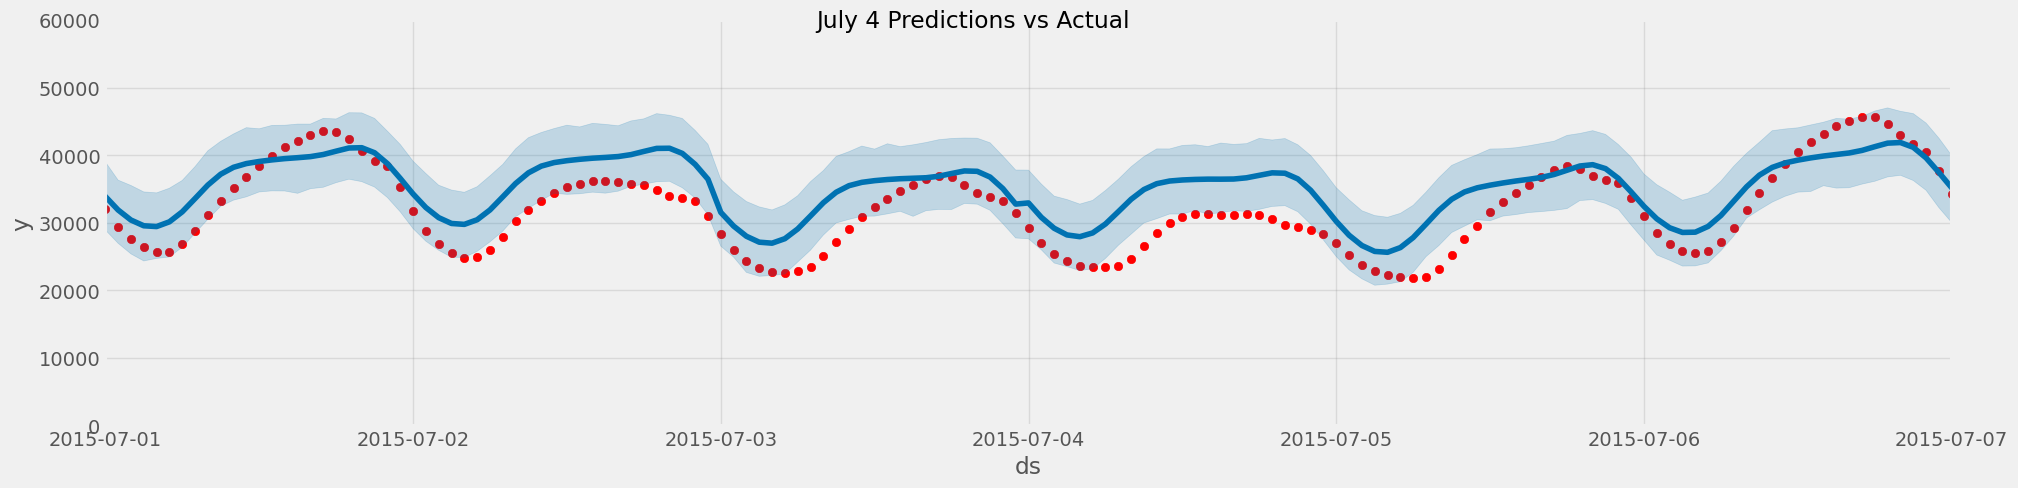

In [49]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='07-01-2015',
              upper='07-07-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

In [50]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

6639.802219208022

In [51]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5200.950215632645

In [52]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.561843563259924

In [53]:
###Predict into the Future

In [71]:
future = model.make_future_dataframe(periods=365*24*5, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [72]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,25533.155856
1,2015-01-01 02:00:00,24031.245054
2,2015-01-01 03:00:00,23161.693677
3,2015-01-01 04:00:00,23021.999361
4,2015-01-01 05:00:00,23697.885060


In [73]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
43795,2019-12-30 20:00:00,29547.479425,-44284.254048,112791.377024,-50637.081056,108083.224253,0.0,0.0,0.0,0.0,...,1223.237212,1223.237212,1223.237212,632.357160,632.357160,632.357160,0.0,0.0,0.0,35854.154364
43796,2019-12-30 21:00:00,29547.440573,-44174.898434,113080.358047,-50642.011805,108085.452816,0.0,0.0,0.0,0.0,...,1265.799832,1265.799832,1265.799832,632.143325,632.143325,632.143325,0.0,0.0,0.0,35141.283279
43797,2019-12-30 22:00:00,29547.401721,-46400.286462,112563.954830,-50646.942554,108087.681380,0.0,0.0,0.0,0.0,...,1300.739763,1300.739763,1300.739763,631.961058,631.961058,631.961058,0.0,0.0,0.0,33564.599503
43798,2019-12-30 23:00:00,29547.362869,-48176.815555,109429.633240,-50651.873303,108089.909943,0.0,0.0,0.0,0.0,...,1328.433727,1328.433727,1328.433727,631.810445,631.810445,631.810445,0.0,0.0,0.0,31402.518964
43799,2019-12-31 00:00:00,29547.324017,-52088.644453,106370.004808,-50656.804052,108092.138506,0.0,0.0,0.0,0.0,...,1349.306788,1349.306788,1349.306788,631.691571,631.691571,631.691571,0.0,0.0,0.0,29116.338335


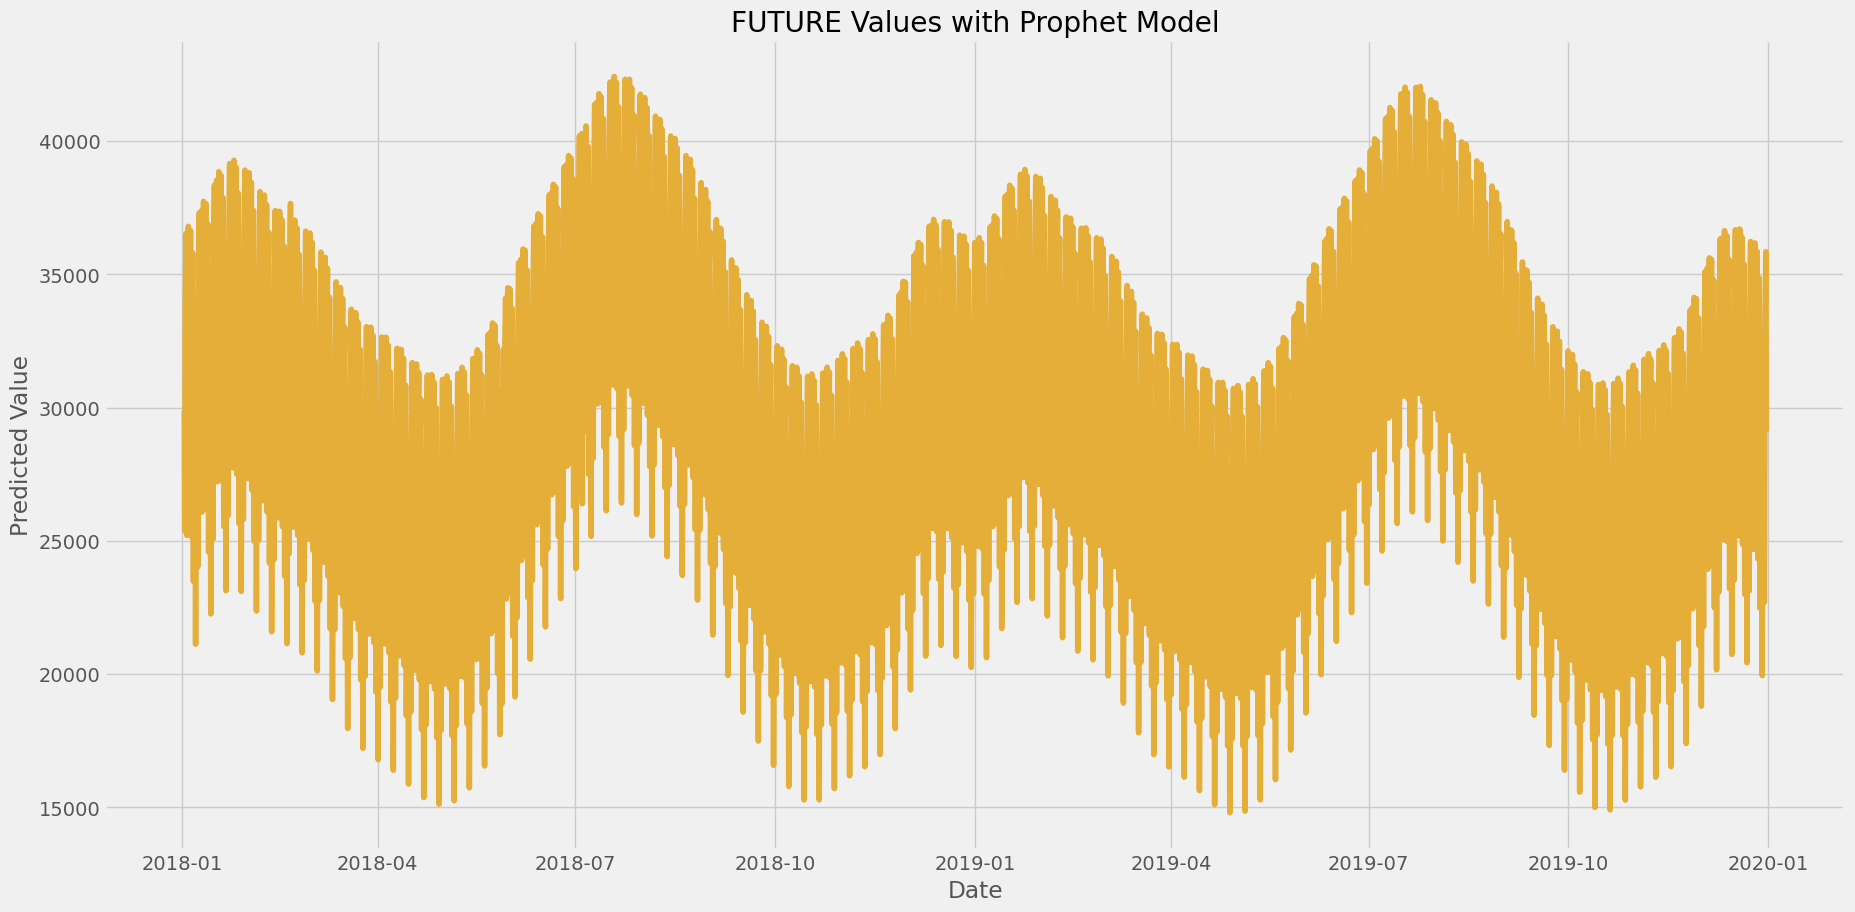

In [83]:

# Create the plot
forecast = forecast[forecast['ds'] >= '2018-01-02 00:00:00']

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(forecast['ds'], forecast['yhat'], color=color_pal[2], label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Predicted Value')
ax.set_title('FUTURE Values with Prophet Model')

plt.show()
